In [1]:
import __init__ # set up all the correct referenses
import os

subproject_name = "trajectories"

wd = "../../../"
project_path = os.path.realpath(wd)
print(project_path)

raw_data_dir = project_path+"/raw_data/"
print(raw_data_dir)


data_dir = project_path+f"/{subproject_name}"+"/data/"
print(data_dir)

results_dir = project_path+f"/{subproject_name}"+"/output"
print(results_dir)

import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KDTree, kneighbors_graph
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer, QuantileTransformer
import sklearn.preprocessing as preprocessing
from sklearn.manifold import TSNE

from sknetwork.clustering import Louvain, get_modularity

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from phenograph.cluster import cluster as cluster2
from phenograph.cluster import run_leiden 


cmap = plt.get_cmap("tab20")

import __init__
#from utils.propensity import Propensity
#from utils.lifelines_preprocess import surv_functions
#from utils.sequence_analysis import trajectory_seq_analysis

import leidenalg
import igraph as ig

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re


key_match_raw = pd.read_csv("/exports/reum/knevel_lab/pseudo_id_old_to_new/id_link.csv")

/exports/reum/nsteinz/Project_trajectories
/exports/reum/nsteinz/Project_trajectories/raw_data/
/exports/reum/nsteinz/Project_trajectories/trajectories/data/
/exports/reum/nsteinz/Project_trajectories/trajectories/output


In [2]:
dmards = ['ABATACEPT',
       'ADALIMUMAB', 'AZATHIOPRINE', 'BARICITINIB', 'CERTOLIZUMAB_PEGOL',
       'CYCLOPHOSPHAMIDE', 'ETANERCEPT', 'GOLIMUMAB', 'HYDROXYCHLOROQUINE',
       'INFLIXIMAB', 'LEFLUNOMIDE', 'METHOTREXATE',
       'RITUXIMAB', 'SODIUM_AUROTHIOMALATE', 'SULFASALAZINE',
       'TOCILIZUMAB', 'TOFACITINIB']
dmard_types = {
    "TNF_b_dmards" : ['ETANERCEPT', 'GOLIMUMAB','INFLIXIMAB','CERTOLIZUMAB_PEGOL', 'ADALIMUMAB'],
    "IL6_b_dmards" : ['CERTOLIZUMAB_PEGOL'],
    "IL1_b_dmards" : ['TOCILIZUMAB'],
    "tcell_b_dmards" : ['ABATACEPT'],
    "cd20_b_dmards" : ['RITUXIMAB'],
    "cs_dmards" : ["METHOTREXATE",'HYDROXYCHLOROQUINE','LEFLUNOMIDE', 'SULFASALAZINE'],
    "jak_dmard" : ['TOFACITINIB', 'BARICITINIB'],
    "XO_damrd" : ['AZATHIOPRINE'],
    "OP_dmard" : ["CYCLOPHOSPHAMIDE"],
    "predni":   ['PREDNISOLONE',"METHYLPREDNISOLONE"],
}
predni=   ['PREDNISOLONE',"METHYLPREDNISOLONE"]
#predni =  ['PREDNISOLONE',"METHYLPREDNISOLONE"]

In [3]:
med_data = pd.read_csv(raw_data_dir + 'data_03_12_22/NewPatSelection_Medicator_formatted_20221202.csv', sep='|',)
med_data = med_data.rename(columns={"patnr":"PATNR"})
med_data.startDate = pd.to_datetime(med_data.startDate)
med_data.PEC = pd.to_datetime(med_data.PEC)
med_data.endDate = pd.to_datetime(med_data.endDate)
data_heatmap_raw = pd.read_csv(data_dir+ "predictie_data.csv",)
med_data = med_data.merge(med_data.groupby("PATNR")['PEC'].min().reset_index().rename(columns={"PEC":"first_visit"}))

In [4]:
med_data.drugName.unique()
dmards = ['METHOTREXAAT', 'HYDROXYCHLOROQUINE', 'SULFASALAZINE',
       'ETANERCEPT', 'ADALIMUMAB', 'LEFLUNOMIDE',
       'CERTOLIZUMAB PEGOL', 'TOCILIZUMAB',
       'AZATHIOPRINE',  'ABATACEPT', 'INFLIXIMAB',
       'BARICITINIB', 'GOLIMUMAB', 
        'TOFACITINIB', 'ANAKINRA']
med_data = med_data.query("drugName in @dmards")

In [5]:
pat_data = data_heatmap_raw.query("days == 0")[["PATNR","global_trajectory"]]

In [6]:
full_data = med_data.merge(pat_data)

In [7]:
full_data = full_data.query("drugName not in ['PREDNISOLON', 'PREDNISOLONE','METHYLPREDNISOLON']")
full_data['delta_time'] = (full_data['startDate'] - full_data['first_visit']).dt.days
full_data['delta_time_end'] = (full_data['endDate'] - full_data['first_visit']).dt.days
full_data['weeks_from_baseline'] = full_data['delta_time'] / 7


In [8]:
last_data = full_data.query("endDate < '2030-01-01'").sort_values("endDate").groupby("PATNR").tail(1)[["PATNR","delta_time_end"]].rename(columns={"delta_time_end":"last_update"})


In [9]:
def check_shift(group, look_up_id=1, shift=-1):
    try:
        group = group.copy().sort_values("delta_time").reset_index()
        group['row_id'] = range(1, len(group) + 1)
        look_up_row = group[group['row_id'] == look_up_id]
        shift_row = group[group['row_id'] == look_up_id + shift]
        
        if (abs(look_up_row['delta_time'].iloc[0] - shift_row['delta_time'].iloc[0]) <= 30 and
            shift_row['drugName'].iloc[0] != look_up_row['drugName'].iloc[0]):
            return True
        return False
    except:
        return False

def calculate_combo(group):
    treatment_id = 0
    combo = pd.Series([np.nan] * len(group), index=group.index)
    
    for i in range(len(group)):
        if check_shift(group, i+1, -1) or check_shift(group, i+1, 1):
            combo.iloc[i] = treatment_id
        else:
            treatment_id += 1
            combo.iloc[i] = np.nan
    
    group['combo'] = combo
    return group

# Sort and group data
dmard_data = full_data.sort_values('startDate')
dmard2 = dmard_data.groupby('PATNR', group_keys=True).apply(calculate_combo).reset_index(drop=True)

# Process combination sets
comba_set = (dmard2[~dmard2['combo'].isna()]
             .groupby(['PATNR', 'combo'])
             .agg({
                 'drugName': lambda x: ', '.join(sorted(set(x))),
                 'startDate': 'min',
                 'delta_time': 'min',
                 'delta_time_end': 'max'
             })
             .reset_index()
             .rename(columns={
                 'drugName': 'medication_name',
                 'startDate': 'combi_start_date',
                 'delta_time': 'combi_delta_time',
                 'delta_time_end': 'combi_delta_time_stop'
             }))

# Merge and process final dataset


# Final aggregation


/tmp/ipykernel_1321369/2291393841.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dmard2 = dmard_data.groupby('PATNR', group_keys=True).apply(calculate_combo).reset_index(drop=True)


In [13]:
dmard3 = pd.merge(dmard2, comba_set, on=['PATNR', 'combo'], how='left')
dmard3['medication_name'].fillna(dmard3['drugName'], inplace=True)
dmard3['combi_start_date'].fillna(dmard3['startDate'], inplace=True)
dmard3['combi_delta_time'].fillna(dmard3['delta_time'], inplace=True)
dmard3['combi_delta_time_stop'].fillna(dmard3['delta_time'], inplace=True)


/tmp/ipykernel_1321369/881572127.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dmard3['medication_name'].fillna(dmard3['drugName'], inplace=True)
/tmp/ipykernel_1321369/881572127.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [14]:
dmard4 = (dmard3.groupby(['PATNR', 'combi_start_date'])
          .head(1)
          .assign(
              drugName=lambda x: x['medication_name'],
              treatment_start_date=lambda x: x['combi_start_date'],
              delta_time=lambda x: x['combi_delta_time']
          ))
    
dmard_data = dmard4

In [15]:
["METHOTREXAAT"] in ["METHOTREXAAT", "HYDROXYCHLOROQUINE"]
first_medication = "HYDROXYCHLOROQUINE, METHOTREXAAT"


In [16]:
first_medication="METHOTREXAAT"
partial_data = dmard_data.sort_values(["PATNR","startDate"])
start_first = (partial_data.groupby(['PATNR', 'delta_time'])
                  .head(1)
                  .query('medication_name == @first_medication')
                  .PATNR.unique())
start_first
second_dmard = (partial_data[partial_data['PATNR'].isin(start_first)]
                   .sort_values('delta_time')
                   .query('medication_name != @first_medication | medication_name not in @first_medication'))
second_dmard
(partial_data[partial_data['PATNR'].isin(start_first)]
                   .sort_values(["PATNR",'delta_time'])
                   .query('medication_name != @first_medication |  medication_name not in @first_medication |  medication_name.str.split(",") in @first_medication'))

(partial_data[partial_data['PATNR'].isin(start_first)]
                   .sort_values(["PATNR",'delta_time'])
                     .query('medication_name != @first_medication')
                     .query('@first_medication not in medication_name.str.split(",") ', engine="python")
 .medication_name.str.split(",")
                    
)

26                                    [HYDROXYCHLOROQUINE]
27                                    [HYDROXYCHLOROQUINE]
28                                    [HYDROXYCHLOROQUINE]
29                                    [HYDROXYCHLOROQUINE]
30                                    [HYDROXYCHLOROQUINE]
                               ...                        
41007                  [HYDROXYCHLOROQUINE,  METHOTREXAAT]
41009                                 [HYDROXYCHLOROQUINE]
41010                                 [HYDROXYCHLOROQUINE]
41011                                 [HYDROXYCHLOROQUINE]
41013    [ADALIMUMAB,  HYDROXYCHLOROQUINE,  METHOTREXAA...
Name: medication_name, Length: 7259, dtype: object

In [17]:
def k_medication_switch(big_dataset, partial_dataset=None, k_th=2, first_medication="METHOTREXAAT"):
    """
    Analyze medication switches recursively
    Parameters:
        big_dataset (pd.DataFrame): Complete medication dataset
        partial_dataset (pd.DataFrame): Subset of data for analysis
        k_th (int): Switch iteration number
        first_medication (str): Initial medication to analyze
    """
    if k_th <= 1:
        if partial_dataset is None:
            return pd.DataFrame()
        return (partial_dataset[partial_dataset['drugName'] == first_medication]
                [['PATNR', 'drugName', 'delta_time', 'delta_time_end', 'weeks_from_baseline']])
    
    # Step 1: Filter patients who start with the first medication
    start_first = (partial_dataset.groupby(['PATNR', 'delta_time'])
                  .head(1)
                  .query('drugName == @first_medication')
                  .PATNR.unique())
    #print(start_first)
    
    # Step 2: Find the second medication
    second_dmard = (big_dataset[big_dataset['PATNR'].isin(start_first)]
                   .sort_values('delta_time')
                   .query('drugName != @first_medication | ~medication_name.str.contains(@first_medication)', engine='python'))
    
    #print(f"Number of second DMARD records: {len(second_dmard)}")
    
    # Step 3: Identify the start of the second medication
    second_med_start = (second_dmard.groupby('PATNR')
                       .head(1)
                       .reset_index(drop=True))
    
    # Step 4: Identify patients who switch to combinations
    combi_after = (second_dmard.groupby(['PATNR', 'delta_time'])
                  .size()
                  .reset_index(name='Treatment_ID')
                  .sort_values('delta_time')
                  .groupby('PATNR')
                  .head(1)
                  .query('Treatment_ID >= 2')['PATNR']
                  .unique())
    
    #print(f"Number of combination switches: {len(combi_after)}")
    
    # Step 5: Process combination therapies
    x = (second_dmard[second_dmard['PATNR'].isin(combi_after)]
         .sort_values('delta_time')
         .groupby(['PATNR', 'delta_time'])
         .agg({'drugName': lambda x: ', '.join(sorted(set(x)))})
         .reset_index()
         .sort_values('delta_time')
         .groupby('PATNR')
         .head(1))
    
    #print(f"Number of processed combinations: {len(x)}")
    
    # Step 6: Identify patients who switch to a single new medication
    single_after = (second_dmard.groupby(['PATNR', 'delta_time'])
                   .size()
                   .reset_index(name='Treatment_ID')
                   .groupby('PATNR')
                   .head(1)
                   .query('Treatment_ID == 1')['PATNR']
                   .unique())
    
    #print(f"Number of single medication switches: {len(single_after)}")
    
    # Step 7: Recursive function call for subsequent switches
    medication_subsets = []
    for medication in second_dmard['drugName'].unique():
        subset = k_medication_switch(
            big_dataset=second_dmard,
            partial_dataset=second_med_start[second_med_start['PATNR'].isin(single_after)],
            k_th=k_th - 1,
            first_medication=medication
        )
        medication_subsets.append(subset)
    if len(medication_subsets)>=2:
        medication_subset = pd.concat(medication_subsets, ignore_index=True)
    elif len(medication_subsets) == 0:
        return None
    else:
        #print(medication_subsets)
        medication_subset = medication_subsets[0]
    return medication_subset

def get_medication_chain(dataset, dmard_start="METHOTREXAAT"):
    med_start = k_medication_switch(dataset.sort_values(["PATNR","startDate"]),
                                    dataset.sort_values(["PATNR","startDate"]),
                                    k_th=1,
                                    first_medication = dmard_start)
    med_start = med_start.sort_values(["PATNR","delta_time"]).groupby("PATNR").head(1)
    second_dmard = k_medication_switch(dataset.sort_values(["PATNR","startDate"]),
                                       dataset.sort_values(["PATNR","startDate"]), 
                                       k_th=2,
                                    first_medication = dmard_start)
    third_dmard  = k_medication_switch(dataset.sort_values(["PATNR","startDate"]),
                                       dataset.sort_values(["PATNR","startDate"]),
                                       k_th=3,
                                      first_medication = dmard_start)
    comb_dmard_start = (med_start
                        .merge(second_dmard,on="PATNR", suffixes=("","_second"), how="left")
                        .merge(third_dmard,on="PATNR", suffixes=("","_third"), how="left")
                        .merge(last_data, how="left")
                        .merge(pat_data))
    return comb_dmard_start
    

med_seection = dmard_data.sort_values(["PATNR","startDate"]).groupby("PATNR").head(1).medication_name.unique()
dmard_data.sort_values(["PATNR","startDate"]).groupby("PATNR").head(1).medication_name.value_counts()

medication_name
METHOTREXAAT                                                                939
HYDROXYCHLOROQUINE                                                           79
SULFASALAZINE                                                                70
LEFLUNOMIDE                                                                  24
HYDROXYCHLOROQUINE, METHOTREXAAT                                             19
ETANERCEPT                                                                   11
HYDROXYCHLOROQUINE, METHOTREXAAT, SULFASALAZINE                               7
AZATHIOPRINE                                                                  7
METHOTREXAAT, SULFASALAZINE                                                   5
ETANERCEPT, METHOTREXAAT                                                      3
ADALIMUMAB                                                                    3
TOCILIZUMAB                                                                   2
ABATACEPT               

In [18]:
med_lijst = []
for dmard in med_seection:
    med_lijst += [get_medication_chain(dmard_data, dmard)]

In [19]:
mtx_start = get_medication_chain(dmard_data)
HCQ_start = get_medication_chain(dmard_data, "HYDROXYCHLOROQUINE")


In [20]:
med_dmard_full = pd.concat(med_lijst).sort_values("delta_time").groupby("PATNR").head(1)

In [21]:
med_dmard_full.groupby(["global_trajectory", "drugName_second"]).delta_time.describe()

count        mean  \
global_trajectory drugName_second                                           
A                 ABATACEPT, HYDROXYCHLOROQUINE           1.0   41.000000   
                  ABATACEPT, METHOTREXAAT                 1.0    2.000000   
                  ADALIMUMAB                              4.0  161.750000   
                  ADALIMUMAB, ETANERCEPT, METHOTREXAAT    1.0    6.000000   
                  ADALIMUMAB, METHOTREXAAT                2.0   21.000000   
...                                                       ...         ...   
D                 LEFLUNOMIDE, SULFASALAZINE              1.0   56.000000   
                  METHOTREXAAT                           19.0  153.263158   
                  METHOTREXAAT, SULFASALAZINE             3.0   14.000000   
                  SULFASALAZINE                           6.0   55.833333   
                  TOCILIZUMAB                             1.0   20.000000   

                                                               std   min  \
global_trajectory drugName_second                                          
A                 ABATACEPT, HYDROXYCHLOROQUINE                NaN  41.0   
                  ABATACEPT, METHOTREXAAT                      NaN   2.0   
                  ADALIMUMAB                            307.509756   5.0   
                  ADALIMUMAB, ETANERCEPT, METHOTREXAAT         NaN   6.0   
                  ADALIMUMAB, METHOTREXAAT               19.798990   7.0   
...                                                            ...   ...   
D                 LEFLUNOMIDE, SULFASALAZINE                   NaN  56.0   
                  METHOTREXAAT                          376.791254   5.0   
                  METHOTREXAAT, SULFASALAZINE             6.557439   8.0   
                  SULFASALAZINE                          36.334098  26.0   
                  TOCILIZUMAB                                  NaN  20.0   

                                                          25%   50%    75%  \
global_trajectory drugName_second                                            
A                 ABATACEPT, HYDROXYCHLOROQUINE         41.00  41.0   41.0   
                  ABATACEPT, METHOTREXAAT                2.00   2.0    2.0   
                  ADALIMUMAB                             7.25   9.5  164.0   
                  ADALIMUMAB, ETANERCEPT, METHOTREXAAT   6.00   6.0    6.0   
                  ADALIMUMAB, METHOTREXAAT              14.00  21.0   28.0   
...                                                       ...   ...    ...   
D                 LEFLUNOMIDE, SULFASALAZINE            56.00  56.0   56.0   
                  METHOTREXAAT                          21.00  30.0  106.5   
                  METHOTREXAAT, SULFASALAZINE           10.50  13.0   17.0   
                  SULFASALAZINE                         30.00  39.0   79.5   
                  TOCILIZUMAB                           20.00  20.0   20.0   

                                                           max  
global_trajectory drugName_second                               
A                 ABATACEPT, HYDROXYCHLOROQUINE           41.0  
                  ABATACEPT, METHOTREXAAT                  2.0  
                  ADALIMUMAB                             623.0  
                  ADALIMUMAB, ETANERCEPT, METHOTREXAAT     6.0  
                  ADALIMUMAB, METHOTREXAAT                35.0  
...                                                        ...  
D                 LEFLUNOMIDE, SULFASALAZINE              56.0  
                  METHOTREXAAT                          1670.0  
                  METHOTREXAAT, SULFASALAZINE             21.0  
                  SULFASALAZINE                          111.0  
                  TOCILIZUMAB                             20.0  

[81 rows x 8 columns]

In [22]:
med_dmard_full["event"] = (~med_dmard_full.delta_time_second.isna())
med_dmard_full['time_to_event'] = med_dmard_full.delta_time_second
med_dmard_full['time_to_event'] = (med_dmard_full['time_to_event']- med_dmard_full['delta_time']).fillna(med_dmard_full.last_update)
med_dmard_full = med_dmard_full.query("~time_to_event.isnull()")

In [23]:
med_dmard_full["event_third"] = (~med_dmard_full.delta_time_third.isna())
med_dmard_full['time_to_event_third'] = med_dmard_full.delta_time_third
med_dmard_full['time_to_event_third'] = (med_dmard_full['time_to_event_third']- med_dmard_full['delta_time']).fillna(med_dmard_full.last_update)
med_dmard_full = med_dmard_full.query("~time_to_event.isnull()")

In [24]:
med_dmard_full.drugName.unique()

array(['LEFLUNOMIDE', 'ETANERCEPT', 'METHOTREXAAT', 'HYDROXYCHLOROQUINE',
       'TOFACITINIB', 'SULFASALAZINE',
       'ADALIMUMAB, BARICITINIB, HYDROXYCHLOROQUINE, METHOTREXAAT, SULFASALAZINE',
       'HYDROXYCHLOROQUINE, METHOTREXAAT', 'AZATHIOPRINE',
       'ADALIMUMAB, METHOTREXAAT', 'METHOTREXAAT, SULFASALAZINE',
       'ETANERCEPT, METHOTREXAAT',
       'HYDROXYCHLOROQUINE, METHOTREXAAT, SULFASALAZINE',
       'ETANERCEPT, SULFASALAZINE', 'TOCILIZUMAB', 'ABATACEPT',
       'ABATACEPT, AZATHIOPRINE, HYDROXYCHLOROQUINE', 'ADALIMUMAB',
       'GOLIMUMAB, SULFASALAZINE', 'CERTOLIZUMAB PEGOL',
       'ABATACEPT, HYDROXYCHLOROQUINE, METHOTREXAAT',
       'ETANERCEPT, HYDROXYCHLOROQUINE, METHOTREXAAT',
       'ETANERCEPT, LEFLUNOMIDE', 'LEFLUNOMIDE, METHOTREXAAT',
       'HYDROXYCHLOROQUINE, SULFASALAZINE'], dtype=object)

In [25]:
med_dmard_full.columns

Index(['PATNR', 'drugName', 'delta_time', 'delta_time_end',
       'weeks_from_baseline', 'drugName_second', 'delta_time_second',
       'delta_time_end_second', 'weeks_from_baseline_second', 'drugName_third',
       'delta_time_third', 'delta_time_end_third', 'weeks_from_baseline_third',
       'last_update', 'global_trajectory', 'event', 'time_to_event',
       'event_third', 'time_to_event_third'],
      dtype='object')

In [26]:
for i in med_dmard_full.groupby("global_trajectory"):
    print(i[0])
    print(i[1].drugName_second.value_counts())

A
drugName_second
HYDROXYCHLOROQUINE, METHOTREXAAT                                43
HYDROXYCHLOROQUINE                                              39
LEFLUNOMIDE                                                     36
SULFASALAZINE                                                   33
HYDROXYCHLOROQUINE, METHOTREXAAT, SULFASALAZINE                 29
METHOTREXAAT                                                    23
METHOTREXAAT, SULFASALAZINE                                      8
AZATHIOPRINE                                                     5
HYDROXYCHLOROQUINE, SULFASALAZINE                                4
ADALIMUMAB                                                       4
ETANERCEPT                                                       4
TOCILIZUMAB                                                      2
CERTOLIZUMAB PEGOL, SULFASALAZINE                                2
ETANERCEPT, METHOTREXAAT                                         2
ADALIMUMAB, METHOTREXAAT                    

In [29]:
from lifelines.utils import datetimes_to_durations
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
med_dmard_full["start_dmard"] = 1
from utils.lifelines_preprocess import surv_functions

imports worked


In [34]:
med_dmard_full.columns

Index(['PATNR', 'drugName', 'delta_time', 'delta_time_end',
       'weeks_from_baseline', 'drugName_second', 'delta_time_second',
       'delta_time_end_second', 'weeks_from_baseline_second', 'drugName_third',
       'delta_time_third', 'delta_time_end_third', 'weeks_from_baseline_third',
       'last_update', 'global_trajectory', 'event', 'time_to_event',
       'event_third', 'time_to_event_third', 'start_dmard'],
      dtype='object')

(0.0, 550.0)

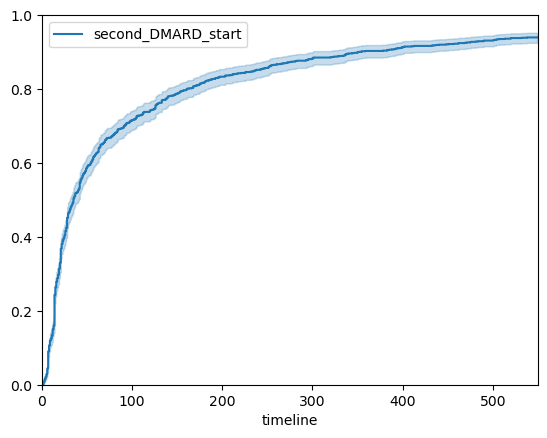

In [56]:


kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(med_dmard_full.delta_time, med_dmard_full.start_dmard , label="second_DMARD_start", timeline=list(range(550)))
kmf.plot_cumulative_density(ax=ax)
plt.ylim(0,1)
plt.xlim(0,550)

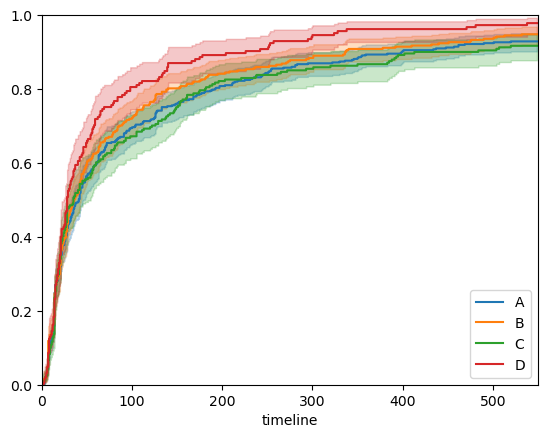

In [55]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
for i in sorted(med_dmard_full.global_trajectory.dropna().unique()):
    data_knf_raw = med_dmard_full.query("global_trajectory == @i ")
    kmf.fit(data_knf_raw.delta_time, data_knf_raw.start_dmard , label=i, timeline=list(range(550)))
    kmf.plot_cumulative_density(ax=ax)
    plt.ylim(0,1)
    plt.xlim(0,550)

(0.0, 1.0)

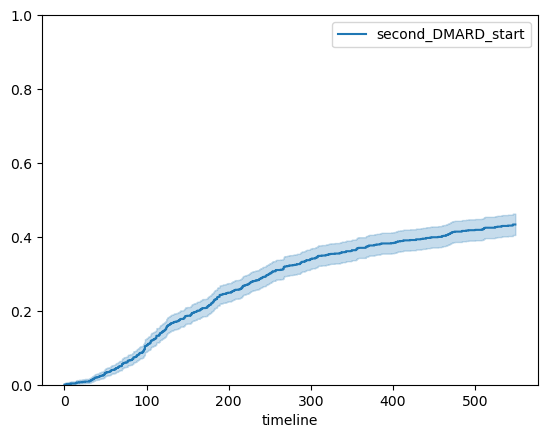

In [44]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(med_dmard_full.time_to_event, med_dmard_full.event , label="second_DMARD_start", timeline=list(range(550)))
kmf.plot_cumulative_density(ax=ax)
plt.ylim(0,1)

<Axes: xlabel='days since first dmard start', ylabel='survival on first dmard'>

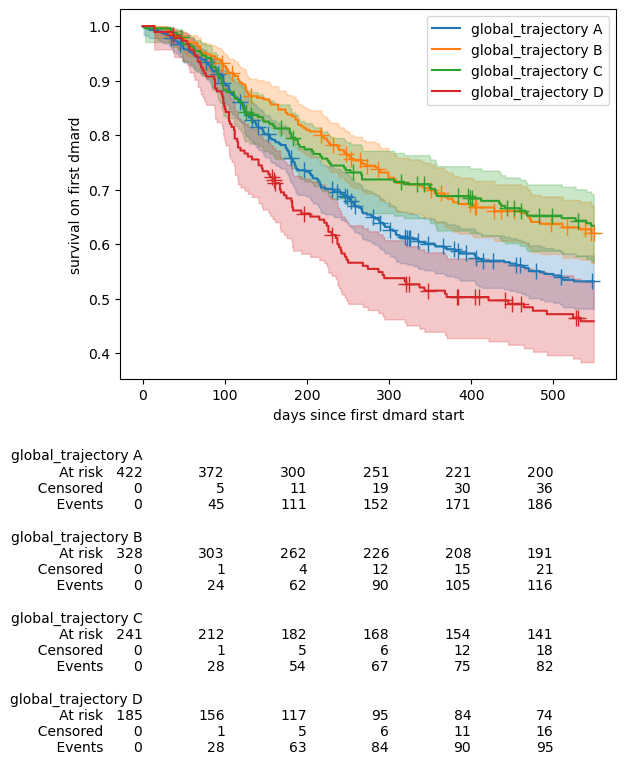

In [45]:
ax = plt.subplot(111)
kmf_list = []
query= "startDate == last_visit"
query= "drugName == 'METHOTREXAAT'"
for i in sorted(med_dmard_full.global_trajectory.unique()):
    kmf_list.append(KaplanMeierFitter())
    data_knf_raw = med_dmard_full.query("global_trajectory == @i ")

    kmf_list[-1].fit(data_knf_raw.time_to_event, data_knf_raw.event, label =f"global_trajectory {i}", timeline=list(range(550)))
    kmf_list[-1].plot_survival_function(ax=ax, show_censors=True)

plt.ylabel("survival on first dmard")
plt.xlabel("days since first dmard start")
add_at_risk_counts(*kmf_list, ax=ax)

In [46]:
data_knf_raw.time_to_event_third.isna()

504    False
621    False
50     False
600    False
58     False
       ...  
215    False
510    False
978    False
0      False
376    False
Name: time_to_event_third, Length: 185, dtype: bool

<Axes: xlabel='days since first dmard start', ylabel='survival on second dmard'>

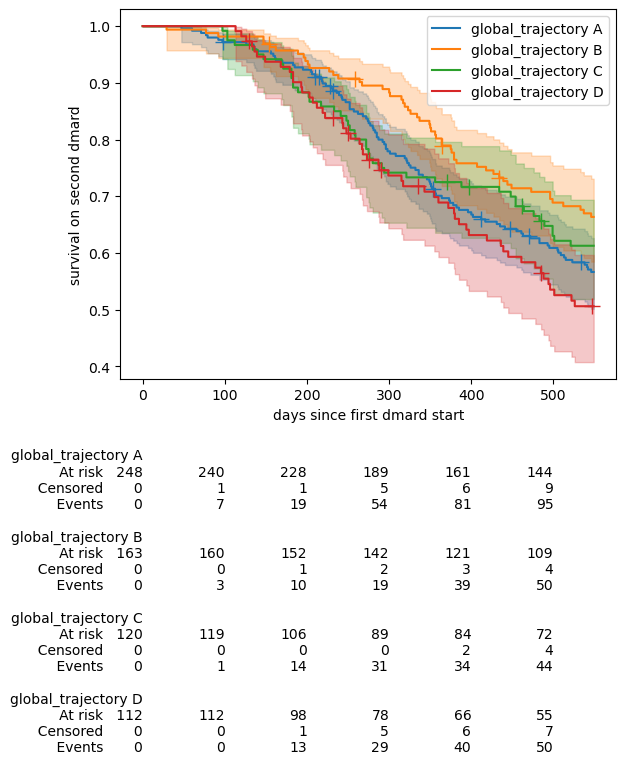

In [47]:
ax = plt.subplot(111)
kmf_list = []
query= "startDate == last_visit"
query= "drugName == 'METHOTREXAAT'"
for i in sorted(med_dmard_full.global_trajectory.unique()):
    kmf_list.append(KaplanMeierFitter())
    data_knf_raw = med_dmard_full.query("global_trajectory == @i ").query("~time_to_event_third.isnull() & event == True")

    kmf_list[-1].fit(data_knf_raw.time_to_event_third, data_knf_raw.event_third, label =f"global_trajectory {i}", timeline=list(range(550)))
    kmf_list[-1].plot_survival_function(ax=ax, show_censors=True)

plt.ylabel("survival on second dmard")
plt.xlabel("days since first dmard start")
add_at_risk_counts(*kmf_list, ax=ax)

In [48]:
from lifelines.statistics import logrank_test
for i in med_dmard_full.global_trajectory.unique():
    for j in med_dmard_full.global_trajectory.unique():
        if i == j:
            continue
        group1 = med_dmard_full.query("global_trajectory == @i")
        group2 = med_dmard_full.query("global_trajectory == @j")
        
        results = logrank_test(
            group1['time_to_event'],
            group2['time_to_event'],
            group1['event'],
            group2['event']
        )
        print(f"{i} vs {j}: p={results.p_value:.3f}")

B vs C: p=0.924
B vs D: p=0.001
B vs A: p=0.002
C vs B: p=0.924
C vs D: p=0.002
C vs A: p=0.008
D vs B: p=0.001
D vs C: p=0.002
D vs A: p=0.278
A vs B: p=0.002
A vs C: p=0.008
A vs D: p=0.278


In [49]:
from lifelines.statistics import logrank_test
for i in med_dmard_full.global_trajectory.unique():
    for j in med_dmard_full.global_trajectory.unique():
        if i == j:
            continue
        group1 = med_dmard_full.query("global_trajectory == @i")
        group2 = med_dmard_full.query("global_trajectory == @j")
        
        results = logrank_test(
            group1['time_to_event_third'],
            group2['time_to_event_third'],
            group1['event_third'],
            group2['event_third']
        )
        print(f"{i} vs {j}: p={results.p_value:.3f}")

B vs C: p=0.559
B vs D: p=0.003
B vs A: p=0.000
C vs B: p=0.559
C vs D: p=0.030
C vs A: p=0.009
D vs B: p=0.003
D vs C: p=0.030
D vs A: p=0.920
A vs B: p=0.000
A vs C: p=0.009
A vs D: p=0.920


In [51]:
mtx_surv = med_dmard_full.query("event == False").PATNR.unique()
mtx_surv = med_dmard_full.query("event == True & event_third == False").PATNR.unique()

In [53]:
med_dmard_full.groupby("global_trajectory").time_to_event_third.describe()

,count,mean,std,min,25%,50%,75%,max
global_trajectory,,,,,,,,
A,421.0,1158.434679,976.210703,35.0,364.0,835.0,1623.0,4113.0
B,328.0,1346.347561,997.297815,29.0,546.0,1041.0,2016.0,3948.0
C,241.0,1370.315353,1047.463937,47.0,483.0,1062.0,2123.0,4105.0
D,185.0,1116.486486,1034.940778,37.0,347.0,754.0,1490.0,4012.0


In [54]:
data_heatmap_raw.query("PATNR in @mtx_surv").sort_values("days").groupby("PATNR").tail(1).groupby("global_trajectory").das28.describe()

,count,mean,std,min,25%,50%,75%,max
global_trajectory,,,,,,,,
A,59.0,3.882074,1.211069,1.514570,2.953489,3.976662,4.828320,7.076796
B,52.0,2.256933,0.844432,0.684019,1.791847,2.119370,2.580823,5.687140
C,32.0,2.855010,1.273479,0.684019,1.934882,2.770353,3.561093,6.175318
D,32.0,3.358279,1.055476,1.821102,2.584888,3.169817,3.751984,6.022208
